In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-06-21 23:05:40.845588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 23:05:40.892917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-21 23:05:40.892941: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-21 23:05:40.893528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

## Importing Model

In [5]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history, modelsmeta = LoadModel(model_dir)

G_PARAMS.SetParams(modelsmeta)

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("model_history keys: {}".format(model_history.keys()))
print ("modelsmeta: {}".format(modelsmeta))

Found 6 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   ANN 2022-06-21 20:14:08
  [1].   ANN 2022-06-21 22:25:53
  [2].   ANN 2022-06-21 22:34:34
  [3].   ANN 2022-06-21 22:43:27
  [4].   ANN 2022-06-21 22:51:25
  [5].   ANN 2022-06-21 22:55:25
You selected model ANN 2022-06-21 22:55:25

model loaded
model history loaded
model metadata loaded
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])
modelsmeta: (5, 1, 1, [30, 30], ['hralt_m', 'theta_rad', 'aoac_rad', 'cas_mps', 'elv_l_rad', 'N1s_rpm'], ['elv_l_rad', 'N1s_rpm'], True)


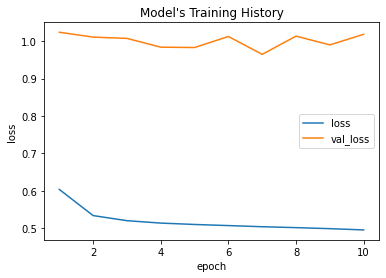

In [6]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

In [7]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.05907484863697578
denormed MAE: -0.08058942777347788
MAE: 1.2326945825217857 deg


## Making Few Predictions

In [8]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 352
	Test count : 61

After Slicing: 
	Train count: 352
	Test count : 61


In [9]:
filename = test_list[0]
os.path.basename(filename)

'flight_28936.csv'

2022-06-21 23:05:51.588432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


timespan: 312.0
mae: 2.803318500518799


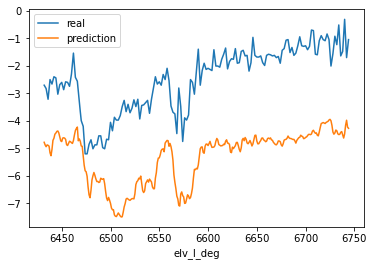

timespan: 312.0
mae: 3.906996011734009


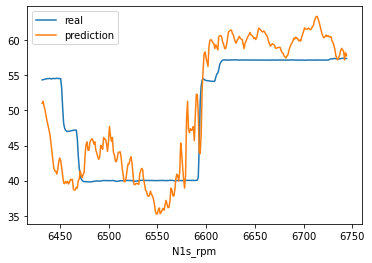

In [10]:
ShowPrediction( 
            "flight_10301.csv",
            model=model,
            window=pred_window
        )

## R2 Results

In [11]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,-6.271576,0.025629,0.001260,0.406994,4.435671,36.950524
std,19.634616,0.022561,0.002656,1.146587,1.379723,25.853753
min,-123.608393,0.005944,0.000075,-7.737440,2.041187,9.077590
25%,-3.066036,0.011935,0.000207,0.501600,3.569007,22.806412
50%,-0.558388,0.017316,0.000455,0.692573,4.219155,29.824404
75%,0.249131,0.032137,0.001228,0.806468,5.123291,47.253231
max,0.829679,0.125592,0.015840,0.896467,11.042008,186.235214


In [12]:
r2_df.nlargest(8, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
54,flight_20048.csv,0.829679,0.007392,0.000077,0.755837,4.784936,41.109821
6,flight_40083.csv,0.652595,0.008678,0.000110,0.833916,3.715849,22.230812
43,flight_36729.csv,0.635124,0.007534,0.000092,0.692573,4.807193,40.081665
3,flight_12806.csv,0.624072,0.006918,0.000083,0.678050,4.176213,34.935043
38,flight_17701.csv,0.619180,0.009470,0.000143,-0.307198,5.816574,59.257172
27,flight_18572.csv,0.586767,0.005944,0.000075,0.863113,2.402495,10.627936
20,flight_31632.csv,0.586277,0.014815,0.000285,0.501600,4.557036,33.949463
49,flight_31872.csv,0.542965,0.011418,0.000190,-0.051037,5.558818,64.733238


In [13]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
10,flight_21884.csv,-123.608393,0.125592,0.015840,0.491637,4.874955,36.211971
55,flight_22498.csv,-79.107837,0.113827,0.013066,0.793479,3.596056,31.208086
19,flight_40945.csv,-47.605839,0.077340,0.006197,0.104823,6.286237,61.063339
30,flight_16365.csv,-28.174705,0.054035,0.003007,0.156152,3.563964,21.110922
28,flight_24058.csv,-16.950952,0.048025,0.002368,0.849077,3.501651,24.590818
18,flight_21056.csv,-16.532217,0.048680,0.002408,0.861175,2.870945,13.429091
60,flight_15032.csv,-9.735316,0.038858,0.001557,0.806468,4.142840,25.540136
52,flight_39366.csv,-7.867946,0.041156,0.001746,-1.286444,3.397101,24.910580
14,flight_11823.csv,-5.569125,0.028912,0.001037,0.190418,5.238402,53.402489
39,flight_10301.csv,-5.156711,0.048927,0.002555,0.641046,3.906996,22.806412


filename: flight_33369.csv
timespan: 254.0
mae: 0.4090427756309509


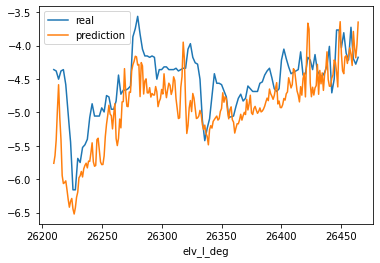

timespan: 254.0
mae: 3.660219669342041


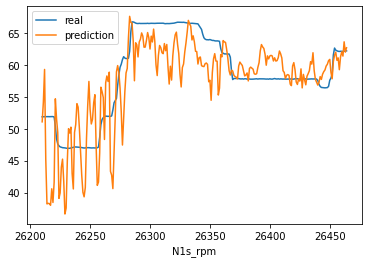

In [14]:
filename_to_predict = "flight_33369.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window)

min: 201.0
max: 428.0
avg: 316.8196721311475


(array([3., 0., 0., 0., 0., 3., 1., 2., 4., 3., 5., 1., 1., 1., 3., 2., 7.,
        2., 2., 3., 1., 4., 5., 2., 0., 2., 3., 0., 0., 1.]),
 array([201.        , 208.56666667, 216.13333333, 223.7       ,
        231.26666667, 238.83333333, 246.4       , 253.96666667,
        261.53333333, 269.1       , 276.66666667, 284.23333333,
        291.8       , 299.36666667, 306.93333333, 314.5       ,
        322.06666667, 329.63333333, 337.2       , 344.76666667,
        352.33333333, 359.9       , 367.46666667, 375.03333333,
        382.6       , 390.16666667, 397.73333333, 405.3       ,
        412.86666667, 420.43333333, 428.        ]),
 <BarContainer object of 30 artists>)

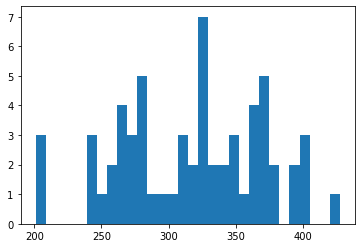

In [15]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [16]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

0

### Make Predictions

In [17]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_label)
                ax.plot (denormed_time, denormed_pred)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                if j == 1 or j == 3:
                    ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

/tmp/ipykernel_61960/4053967539.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


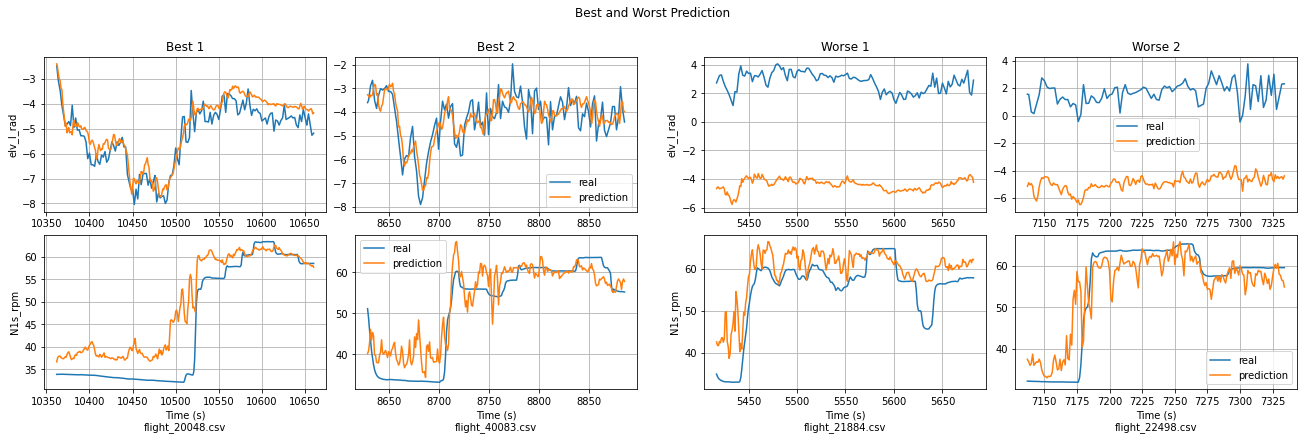

In [18]:
def plot_best_and_worst(metric_label = ["r2_elv_l_rad"]):
    best_list = list(r2_df.nlargest(10, columns=metric_label).iloc[:2, 0])
    worst_list = list(r2_df.nsmallest(10, columns=metric_label).iloc[:2, 0])
    flight_list = best_list + worst_list

    important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

    fig = plt.figure(constrained_layout=True)

    rows = len(G_PARAMS.SEQUENTIAL_LABELS)
    cols = 4

    gs = fig.add_gridspec(rows, cols)

    for j in range(cols):
        big_title = important_title[j]
        flightname = flight_list[j]
        denormed_time, prediction_dict = Predict(
                                            filename=flightname,
                                            model=model,
                                            window=pred_window,
                                            NORM_PARAM=NORM_PARAM
                                        )
        
        for i in range(rows):
            label_index = i % rows
            label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

            denormed_label, denormed_pred = prediction_dict[label]

            ax = fig.add_subplot(gs[i, j])
            ax.plot (denormed_time, denormed_label)
            ax.plot (denormed_time, denormed_pred)
            ax.grid()

            if label_index == 0:
                ax.set_title(big_title)
            if label_index == rows-1:
                ax.set_xlabel("Time (s)" + "\n" + flightname)

            if j == 0 or j == 2:
                ax.set_ylabel('\n'*j + label)
            if j == 1 or j == 3:
                ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Best and Worst Prediction\n")
    fig.show()


metric_label = ["r2_elv_l_rad"]
plot_best_and_worst(metric_label)

/tmp/ipykernel_61960/4126840474.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


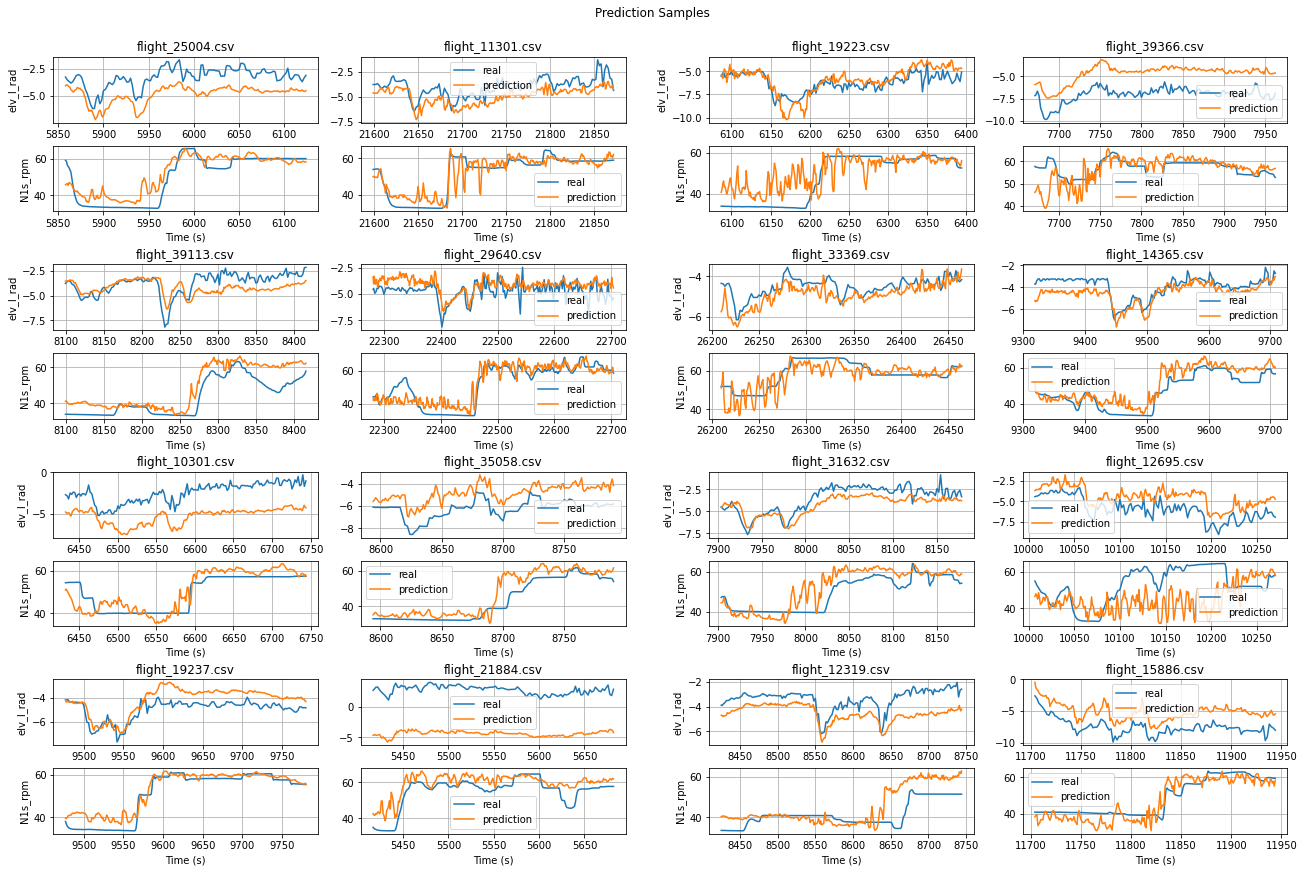

In [19]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)